In [57]:
import collections
import pathlib
import sys

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(pathlib.Path("..").resolve()))

from source import config
from source.data import create_splits

In [58]:
path = config.DATASET_DIR
df = pd.read_csv(path.joinpath("gutenberg_metadata.csv"))

In [59]:
df = df[df["LoCC"].notna()]
df["LoCC"] = df["LoCC"].apply(lambda x: [s.strip() for s in x.split(";")])
df = df.explode(["LoCC"])
df = df[df["Language"] == "en"]

In [60]:
def bars(df, title: str, x_label: str = "Клас LoCC", y_label: str = "Кількість", threshold: int = None):
    plt.figure(figsize=(15, 8))
    df.plot(kind="bar", color="blue")
    plt.title(title, fontsize=20)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.xticks(rotation=0, ha="right", fontsize=14)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--")
    if threshold:
        plt.axhline(y=threshold, color="red", linestyle="--")
    plt.show()

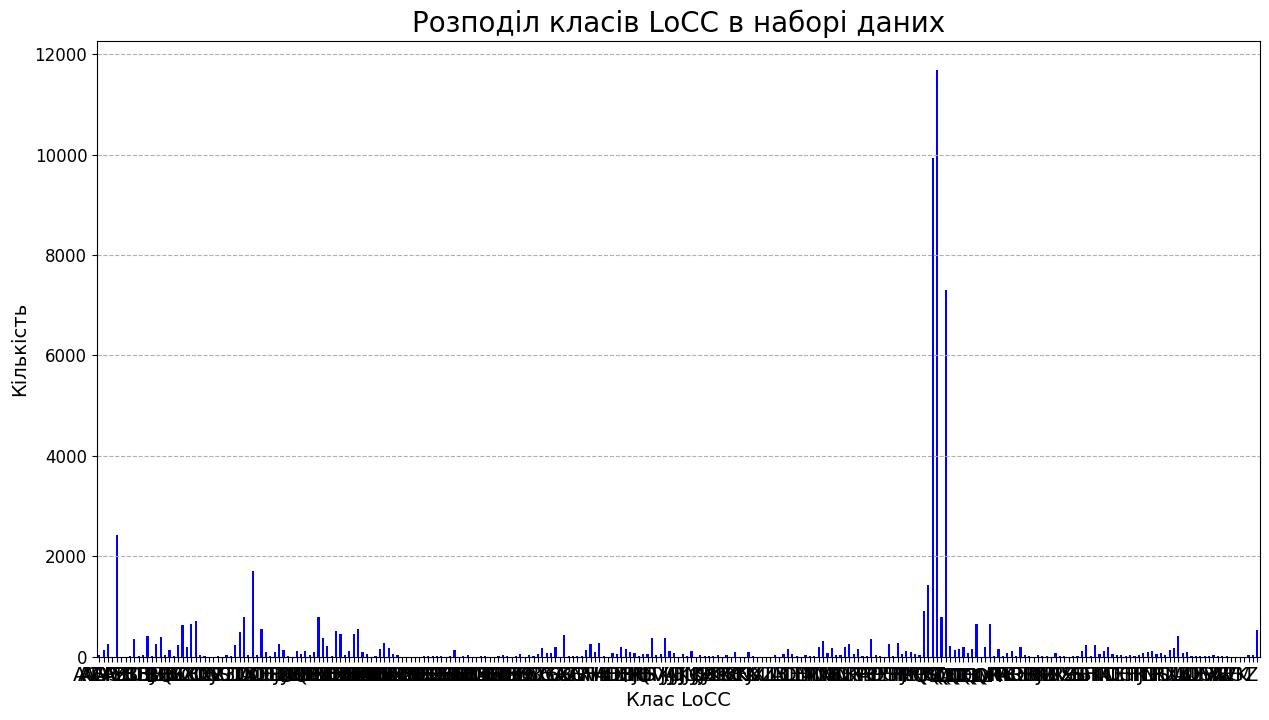

In [61]:
bars(df["LoCC"].value_counts().sort_index(), "Розподіл класів LoCC в наборі даних")

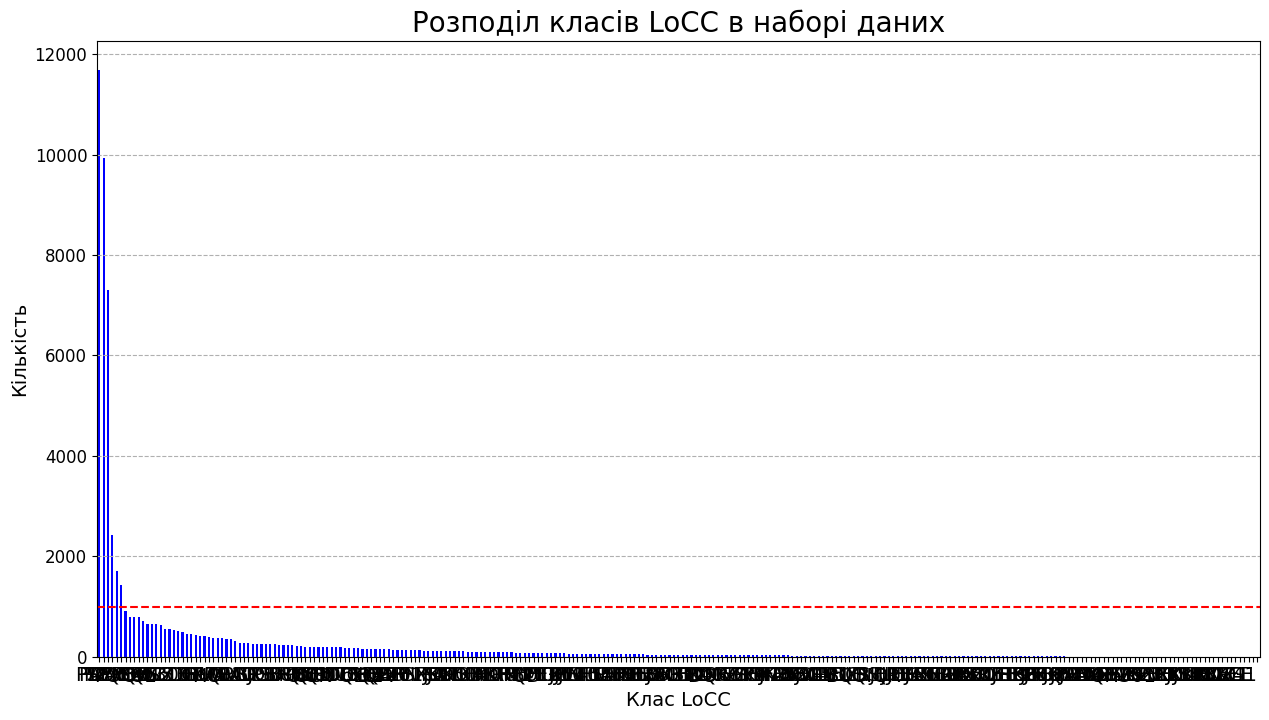

In [62]:
bars(df["LoCC"].value_counts().sort_values(ascending=False), "Розподіл класів LoCC в наборі даних", threshold=1000)

In [63]:
f = df["LoCC"].value_counts()

In [64]:
len(df[~df["LoCC"].isin(f[f > 1000].index.tolist())])

28153

In [65]:
classes = {}

def explode_locc(locc: str):  # (locc="AB123") => ["A", "AB", "AB123"]
    classes = []
    for i, c in enumerate(locc):
        if c.isalpha():
            classes.append(locc[:i+1])
        else:
            classes.append(locc)
            break
    return classes

for cls in df["LoCC"].unique():
    p = explode_locc(cls)
    curr = classes
    for i, k in enumerate(p):
        if k not in curr:
            curr[k] = {}
        curr = curr[k]

In [66]:
ld = df["LoCC"].value_counts().to_dict()

In [67]:
totals = collections.defaultdict(int)

def parse_dict(key, value):
    if len(value) == 0:
        totals[key] = ld[key]
        return
    for k, v in value.items():
        if k not in totals:
            parse_dict(k, v)
        totals[key] += totals[k]

for key, value in classes.items():
    parse_dict(key, value)

In [68]:
MINSUM = 2000

In [69]:
to_merge = {}

def merge_classes(key, value, target):
    for k, v in value.items():
        merge_classes(k, v, key if totals[key] >= MINSUM else target)
    if totals[key] < MINSUM:
        to_merge[key] = target

for key, value in classes.items():
    merge_classes(key, value, key)

In [70]:
df["LoCC"] = df["LoCC"].apply(lambda x: to_merge.get(x, x))

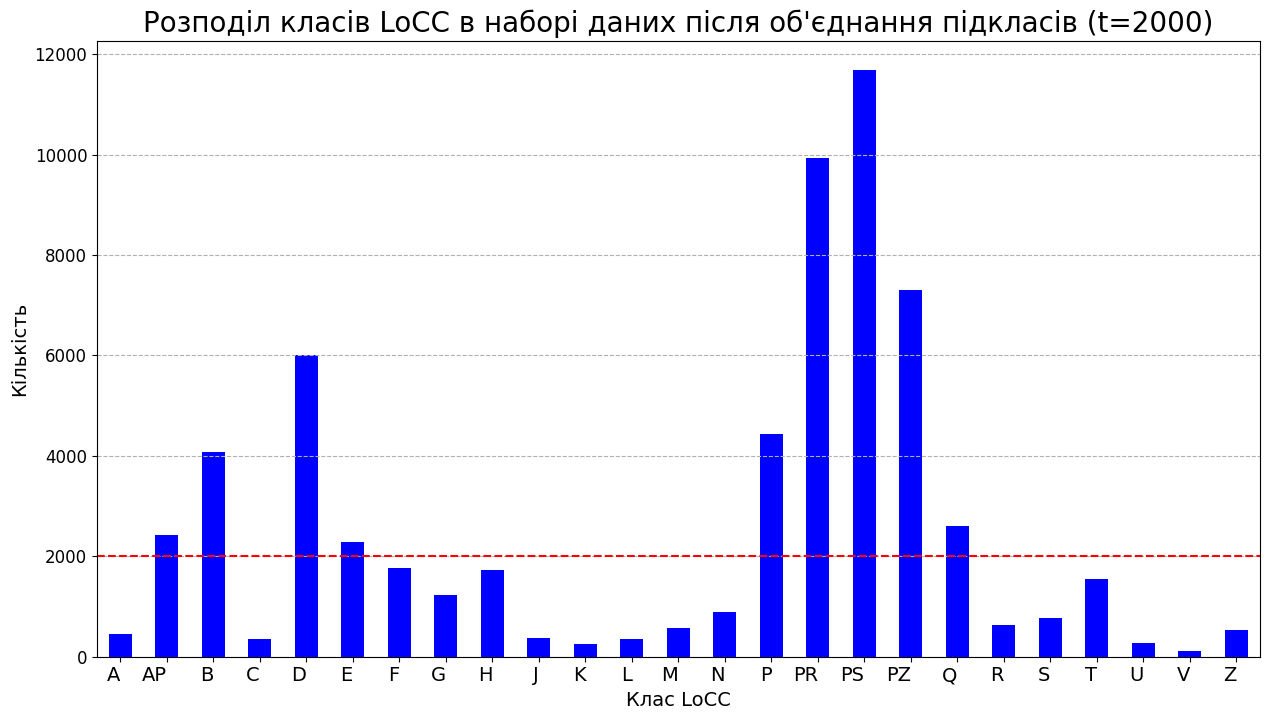

In [72]:
bars(df["LoCC"].value_counts().sort_index(), f"Розподіл класів LoCC в наборі даних після об'єднання підкласів (t={MINSUM})", threshold=MINSUM)

In [73]:
to_merge = {}

for key, value in df["LoCC"].value_counts().to_dict().items():
    if value < MINSUM:
        to_merge[key] = "O"

In [74]:
df["LoCC"] = df["LoCC"].apply(lambda x: to_merge.get(x, x))


In [78]:
df["LoCC"] = df["LoCC"].apply(
    lambda x: x if x[0] not in ["E", "F"] else f"DI{x[1:]}"
)

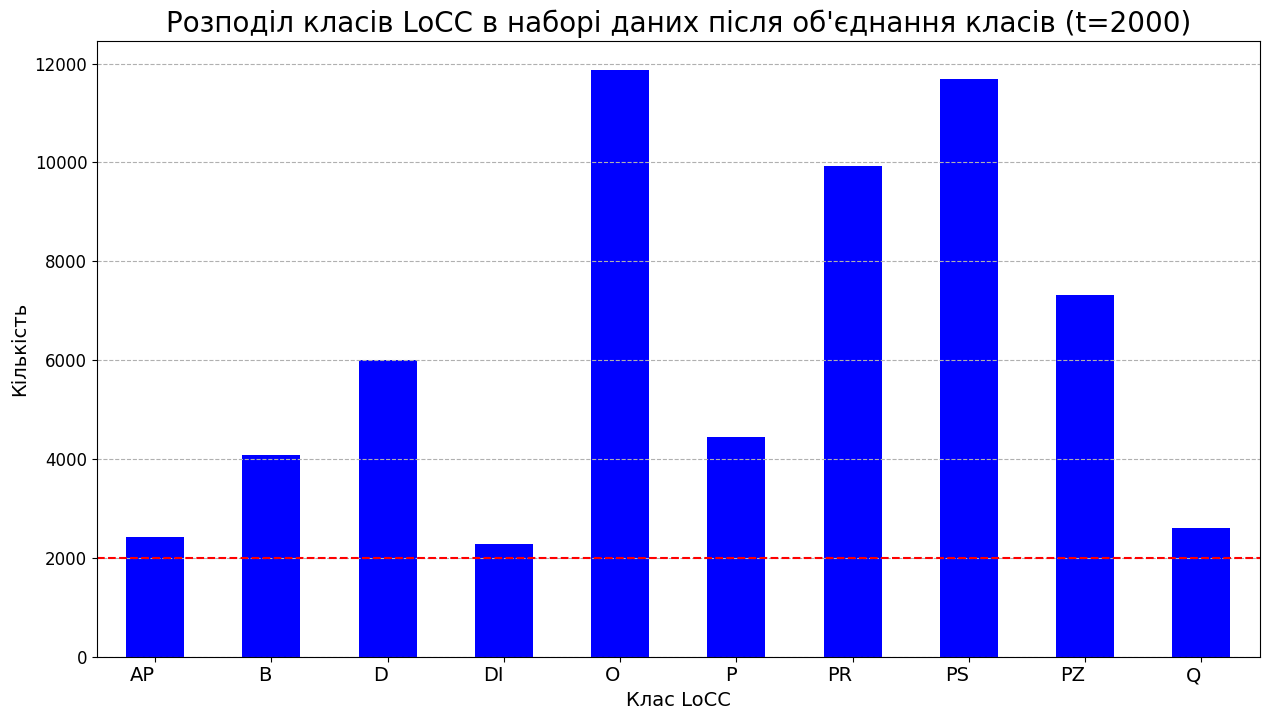

In [79]:
bars(df["LoCC"].value_counts().sort_index(), f"Розподіл класів LoCC в наборі даних після об'єднання класів (t={MINSUM})", threshold=MINSUM)

Step 1/7: 
        Filter out non-text entries and drop not needed columns, drop entries with missing LoCC classes and Etext Number.
        
Data: (57589, 4)
Step 2/7: 
    Explode entries with multiple LoCC classes into multiple rows.
    
Data: (60079, 4)
Step 3/7: 
        Merge classes with less than min_samples entries into the root class.
        
Data: (60079, 4)
Step 4/7: 
        Undersample classes to have at most max_samples entries for each class.
        
Data: (46828, 4)
Step 5/7: 
        Create a train-test split of the dataset.
        
X_train: (32779, 3), X_test: (14049, 3), y_train: (32779,), y_test: (14049,)
Step 6/7: 
    Aggregate entries by Etext Number, merging multiple LoCC classes into a single entry.
    
X_train: (31970, 1), X_test: (13898, 1), y_train: (31970,), y_test: (13898,)
Step 7/7: 
        Oversample classes to have at least min_samples entries for each class.
        
X_train: (35542, 1), X_test: (13898, 1), y_train: (35542,), y_test: (13898,)


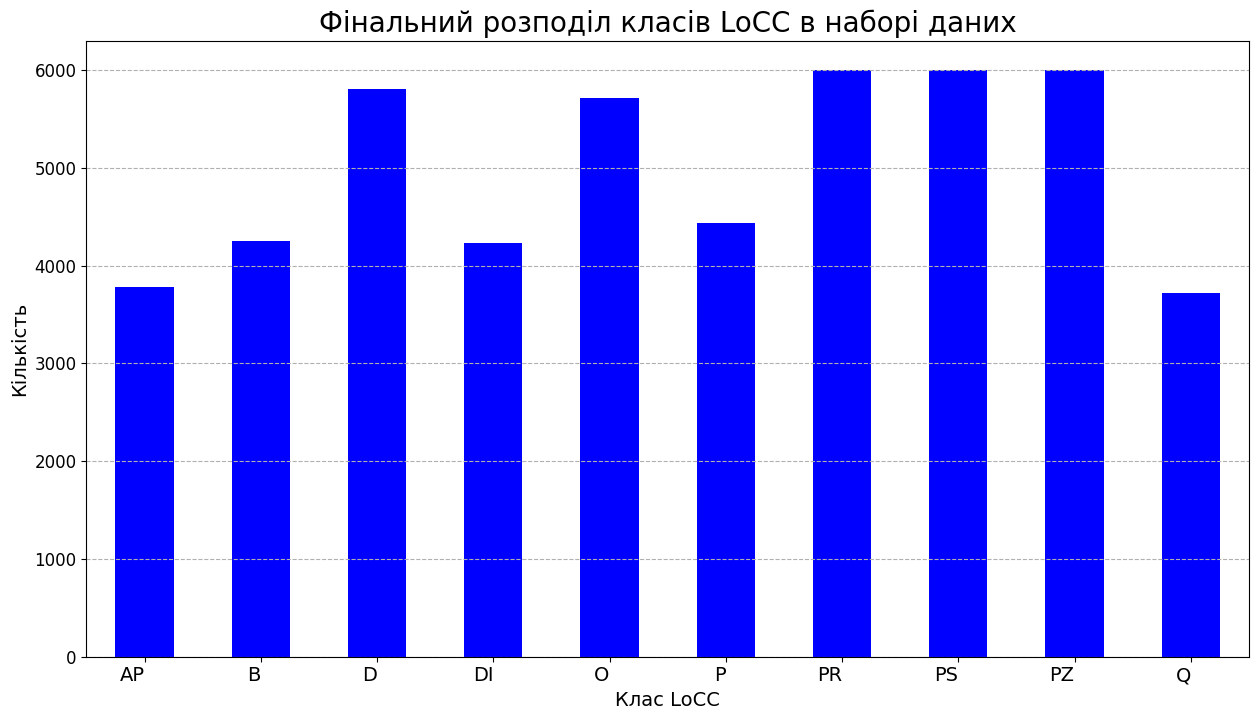

In [76]:
X_train, X_test, y_train, y_test = create_splits()

dff = pd.concat([y_train, y_test])
dff = dff.apply(lambda x: [s.strip() for s in x.split(";")])
dff = dff.explode()

bars(dff.value_counts().sort_index(), "Фінальний розподіл класів LoCC в наборі даних")

In [ ]:
"AP", "B", "D", "DI", "O", "P", "PR", "PS", "PZ", "Q"